In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
tfd = tfp.distributions
import matplotlib.pyplot as plt
%matplotlib inline
tf.enable_eager_execution()

In [2]:
@tf.custom_gradient
def SAWBQuantize(x, alpha, bits):
    # Clip between -alpha and alpha
    clipped = tf.clip_by_value(x, -alpha, alpha)
    # Rescale to [0, alpha]
    scaled = (clipped + alpha) / 2.
    # Quantize.
    quantized = tf.round(scaled * ((2.**bits - 1.) / alpha)) * (alpha / (2.**bits - 1.))
    # Rescale to negative range.
    output = (2 * quantized) - alpha
    
    def grad_fn(dy):
        x_mask = tf.cast(tf.abs(x) <= alpha, tf.float32)
        x_grad = dy * x_mask
        return [x_grad, None, None]
    return output, grad_fn

In [3]:
normal = tfd.Normal(0., 1.)
vonmise = tfd.VonMises(0., 4.)
logistic = tfd.Logistic(0., 1.)
uniform = tfd.Uniform(-1., 1.)
laplace = tfd.Laplace(0., 1.)
triangle = tfd.Triangular(-2., 0., 2.)

distributions = [normal, vonmise, logistic, uniform, laplace, triangle]

In [11]:
alpha_candidates = tf.range(0.1, 10., delta=0.01)
bits = 4

In [12]:
results = []
for dist in distributions:
    samples = dist.sample([100000])
    best_mse = np.inf
    best_alpha = None

    for alpha in alpha_candidates:        
        q_samples = SAWBQuantize(samples, alpha, bits)
        mse = tf.reduce_mean((q_samples - samples)**2)
        #print('alpha: ', alpha.numpy(), 'mse: ', mse.numpy())
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha
            
    #results.append([dist.name, best_alpha, tf.sqrt(tf.reduce_mean(samples**2)), tf.reduce_mean(tf.abs(samples))])
    results.append([best_alpha.numpy() / np.mean(np.abs(samples)), np.sqrt(np.mean(samples**2))/np.mean(np.abs(samples))])
results = np.asarray(results)    

In [13]:
features = results[:,0].reshape(-1, 1)
labels = results[:,1]

In [14]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(features, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [15]:
print(regr.coef_)
print(regr.intercept_)

[0.08428358]
0.98446715


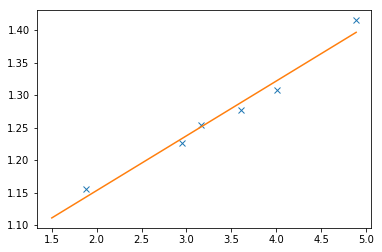

In [16]:
line_x = np.linspace(1.5, np.max(features))
line_y = regr.coef_[0]*line_x + regr.intercept_
plt.plot(results[:,0], results[:,1], 'x')
plt.plot(line_x, line_y)
plt.show()

e2 / e1 = c * a/e1 + i

e2/e1 - i = c * a/e1

e2 - i*e1 = c*a

e2/c - i/c*e1 = a

In [17]:
c1 = 1/regr.coef_[0]
c2 = -regr.intercept_ / regr.coef_[0]
print('c1: ', c1)
print('c2: ', c2)

c1:  11.864706814701913
c2:  -11.680414
